In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import preprocessing
from sklearn.metrics import (accuracy_score, f1_score, 
                             confusion_matrix, recall_score, 
                             classification_report, 
                             roc_curve, roc_auc_score)

## Load Data

In [2]:
data = pd.read_parquet('../data/working_data_lgd.parquet')

In [3]:
loan_data = data.copy()
loan_data

,total_rec_prncp,credit_hist,bankrupt,annual_inc,dti,funded_amnt,recoveries,loan_amnt,int_rate,term_60,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,loan_status,loan_default,grade
13,3481.86,127,1,150000.0,9.39,18000.0,1618.90,18000.0,19.48,1.0,0,0,0,0,0,1,Charged Off,1.0,E
25,1536.90,53,0,35000.0,15.22,4225.0,368.37,4225.0,14.85,0.0,0,0,0,0,0,1,Charged Off,1.0,C
30,13833.12,365,0,65000.0,18.96,16000.0,0.00,16000.0,12.88,0.0,0,1,0,0,0,0,Charged Off,1.0,C
31,1332.69,105,0,75000.0,20.84,24250.0,0.00,24250.0,24.24,1.0,0,1,0,0,0,0,Charged Off,1.0,F
33,8364.55,176,0,79000.0,34.53,25000.0,0.00,25000.0,13.99,1.0,0,1,0,0,0,0,Charged Off,1.0,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260673,747.04,255,0,125000.0,29.89,32000.0,6976.69,32000.0,13.99,1.0,0,1,0,0,0,0,Charged Off,1.0,C
2260677,3606.66,273,0,86000.0,4.80,11200.0,0.00,11200.0,13.49,1.0,0,0,0,0,0,1,Charged Off,1.0,C
2260685,1265.29,361,0,95000.0,21.50,36400.0,0.00,36400.0,14.49,1.0,0,0,0,0,0,1,Charged Off,1.0,C
2260691,1876.47,64,0,157000.0,10.34,32000.0,0.00,32000.0,14.49,1.0,0,1,0,0,0,0,Charged Off,1.0,C


## Variables

Recovery rate = recoveries / funded amount

LGD =  1 - Recovery Rate

In [4]:
loan_data['recovery_rate'] = loan_data['recoveries'] / loan_data['funded_amnt']

In [5]:
loan_data['recovery_rate'].value_counts()

recovery_rate
0.000000    83888
0.012500      180
0.010000      178
0.005000      174
0.025000      160
            ...  
0.197522        1
0.070756        1
0.139479        1
0.056195        1
0.218022        1
Name: count, Length: 165190, dtype: int64

In [6]:
#normalization of recovery rate
loan_data['recovery_rate'] = np.where(loan_data['recovery_rate'] > 1, 1, loan_data['recovery_rate'])
loan_data['recovery_rate'] = np.where(loan_data['recovery_rate'] < 0, 0, loan_data['recovery_rate'])
# We set recovery rates that are greater than 1 to 1 and recovery rates that are less than 0 to 0.

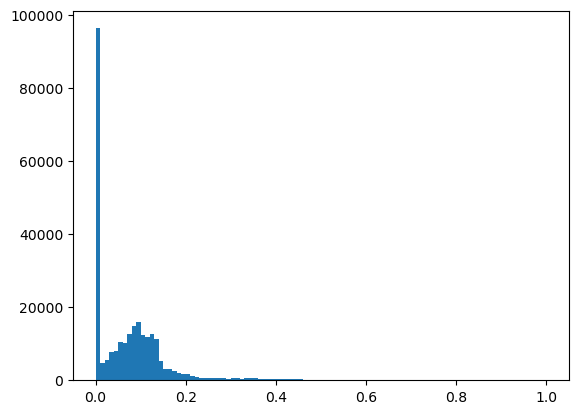

In [7]:
plt.hist(loan_data['recovery_rate'], bins = 100)
plt.show()

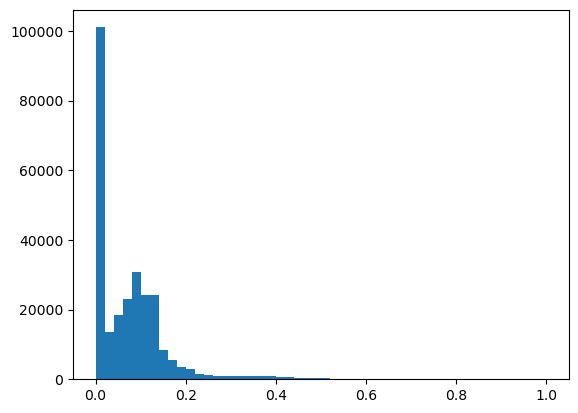

In [8]:
plt.hist(loan_data['recovery_rate'], bins = 50)
plt.show()

In [9]:
loan_data['recovery_rate_0_1'] = np.where(loan_data['recovery_rate'] == 0, 0, 1)

In [10]:
loan_data['recovery_rate_0_1'].value_counts()

recovery_rate_0_1
1    185432
0     83888
Name: count, dtype: int64

In [11]:
loan_data[loan_data["recovery_rate_0_1"] == 1]

,total_rec_prncp,credit_hist,bankrupt,annual_inc,dti,funded_amnt,recoveries,loan_amnt,int_rate,term_60,...,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,loan_status,loan_default,grade,recovery_rate,recovery_rate_0_1
13,3481.86,127,1,150000.0,9.39,18000.0,1618.90,18000.0,19.48,1.0,...,0,0,0,0,1,Charged Off,1.0,E,0.089939,1
25,1536.90,53,0,35000.0,15.22,4225.0,368.37,4225.0,14.85,0.0,...,0,0,0,0,1,Charged Off,1.0,C,0.087188,1
63,10323.88,166,0,106000.0,17.36,35000.0,5558.60,35000.0,12.88,1.0,...,1,0,0,0,0,Charged Off,1.0,C,0.158817,1
65,3175.67,77,0,60000.0,24.29,14000.0,1495.90,14000.0,14.85,1.0,...,1,0,0,0,0,Charged Off,1.0,C,0.106850,1
68,2965.17,176,0,70000.0,16.90,20000.0,9915.00,20000.0,13.99,1.0,...,0,0,0,1,0,Charged Off,1.0,C,0.495750,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260589,354.89,401,0,90000.0,21.47,15000.0,1752.02,15000.0,13.49,1.0,...,0,0,0,0,1,Charged Off,1.0,C,0.116801,1
2260603,2138.82,154,0,70000.0,15.40,16000.0,1038.42,16000.0,14.49,1.0,...,1,0,0,0,0,Charged Off,1.0,C,0.064901,1
2260632,4446.20,172,0,62000.0,11.40,20000.0,3431.19,20000.0,9.49,1.0,...,0,0,0,0,1,Charged Off,1.0,B,0.171560,1
2260643,1112.03,121,1,49400.0,13.85,14400.0,1807.84,14400.0,10.99,1.0,...,0,0,0,1,0,Charged Off,1.0,B,0.125544,1


## LGD Model

Stage 1: Recovery Rate >= 0

In [71]:
X = loan_data.drop(['loan_status', 'loan_default', 'recoveries','recovery_rate','recovery_rate_0_1', 'grade', 'funded_amnt'], axis = 1)
y = loan_data['recovery_rate_0_1']

In [72]:
X

,total_rec_prncp,credit_hist,bankrupt,annual_inc,dti,loan_amnt,int_rate,term_60,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
13,3481.86,127,1,150000.0,9.39,18000.0,19.48,1.0,0,0,0,0,0,1
25,1536.90,53,0,35000.0,15.22,4225.0,14.85,0.0,0,0,0,0,0,1
30,13833.12,365,0,65000.0,18.96,16000.0,12.88,0.0,0,1,0,0,0,0
31,1332.69,105,0,75000.0,20.84,24250.0,24.24,1.0,0,1,0,0,0,0
33,8364.55,176,0,79000.0,34.53,25000.0,13.99,1.0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260673,747.04,255,0,125000.0,29.89,32000.0,13.99,1.0,0,1,0,0,0,0
2260677,3606.66,273,0,86000.0,4.80,11200.0,13.49,1.0,0,0,0,0,0,1
2260685,1265.29,361,0,95000.0,21.50,36400.0,14.49,1.0,0,0,0,0,0,1
2260691,1876.47,64,0,157000.0,10.34,32000.0,14.49,1.0,0,1,0,0,0,0


In [91]:
x_stage_1_train, x_stage_1_test, y_stage_1_train, y_stage_1_test = train_test_split(X, y, test_size = 0.1, random_state = 5)

In [100]:
x_stage_1_test

,total_rec_prncp,credit_hist,bankrupt,annual_inc,dti,loan_amnt,int_rate,term_60,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
1771083,14952.91,293,0,110000.0,21.81,30950.0,22.40,1.0,0,1,0,0,0,0
1063030,1809.62,174,0,60000.0,24.32,9000.0,8.39,0.0,0,0,0,0,0,1
195833,1394.21,182,1,41000.0,18.65,7000.0,9.17,0.0,0,1,0,0,0,0
986881,26688.25,356,0,1500000.0,1.26,35000.0,17.27,0.0,0,0,0,0,1,0
1878929,1941.99,178,0,78000.0,23.82,21000.0,15.80,1.0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191072,7562.39,273,0,128000.0,19.53,34875.0,13.98,1.0,0,1,0,0,0,0
2112023,614.96,361,0,250000.0,27.74,14000.0,16.02,0.0,0,0,0,0,1,0
1014906,413.43,95,0,38000.0,6.16,10000.0,19.99,0.0,0,1,0,0,0,0
407206,4517.07,74,0,28000.0,29.45,10000.0,15.99,1.0,0,0,0,0,0,1


In [92]:
scaler = preprocessing.StandardScaler()

In [93]:
scaled_stage_1 = scaler.fit_transform(x_stage_1_train)

In [94]:
stage_1_model = LogisticRegression(max_iter=200).fit(scaled_stage_1, y_stage_1_train)

probs_stage_1 = stage_1_model.predict_proba(x_stage_1_test)
preds_stage_1 = stage_1_model.predict(x_stage_1_test)

c:\Users\johna\.conda\envs\credit-risk\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\johna\.conda\envs\credit-risk\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [95]:
# Let's grab the probability of the result being a 1
probs_stage_1 = probs_stage_1[: ][: , 1]

In [96]:
df_actual_predicted_probs = pd.concat([pd.DataFrame(preds_stage_1), pd.DataFrame(probs_stage_1)], axis = 1)
df_actual_predicted_probs.columns = ['x_stage_1_test', 'probs_stage_1']
df_actual_predicted_probs.index = x_stage_1_test.index

In [97]:
df_actual_predicted_probs.x_stage_1_test.value_counts()

x_stage_1_test
1    26932
Name: count, dtype: int64

In [98]:
tr = 0.5
df_actual_predicted_probs['y_test_stage_1'] = np.where(df_actual_predicted_probs['probs_stage_1'] > tr, 1, 0)

Confusion Matrix as a Percentage

In [99]:
pd.crosstab(df_actual_predicted_probs['x_stage_1_test'], df_actual_predicted_probs['y_test_stage_1'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]

Predicted,1
Actual,
1,1.0


c:\Users\johna\.conda\envs\credit-risk\Lib\site-packages\sklearn\metrics\_ranking.py:1123: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


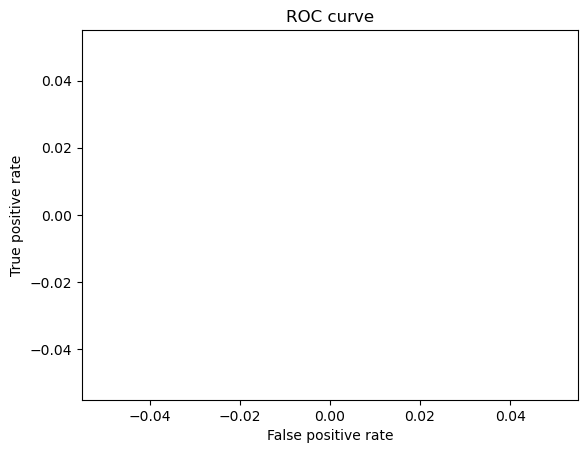

In [82]:
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['x_stage_1_test'], df_actual_predicted_probs['probs_stage_1'])

plt.plot(fpr, tpr)
# We plot the false positive rate along the x-axis and the true positive rate along the y-axis,
# thus plotting the ROC curve.
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
# We plot a seconary diagonal line, with dashed line style and black color.
plt.xlabel('False positive rate')
# We name the x-axis "False positive rate".
plt.ylabel('True positive rate')
# We name the x-axis "True positive rate".
plt.title('ROC curve')
# We name the graph "ROC curve".

plt.show()

In [24]:
AUROC = roc_auc_score(df_actual_predicted_probs['y_test_stage_1'], df_actual_predicted_probs['probs_stage_1'])
# Calculates the Area Under the Receiver Operating Characteristic Curve (AUROC)
# from a set of actual values and their predicted probabilities.
AUROC

1.0